<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/marco-canas/machine_learning/blob/main/classes/class_march_17/clase_march_17_clasificacion_multietiqueta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table> 

# Clase del 17 de Marzo. Clasificación multietiqueta 

Página 159 de Aurelien Geron

Hasta ahora, cada instancia siempre se ha asignado a una sola clase.

En algunos casos, es posible que desee que su clasificador genere múltiples clases para cada instancia.

Considere un **clasificador de reconocimiento facial**: ¿qué debería hacer si reconoce a varias personas en la misma imagen?

Debe adjuntar una etiqueta por persona que reconozca.

Digamos que el clasificador ha sido entrenado para reconocer tres caras, Alice, Bob y Charlie. 

Luego, cuando al clasificador se le muestre una imagen de Alice y Charlie, debería generar [1, 0, 1] (que significa "Alice sí, Bob no, Charlie sí").

Un sistema de clasificación de este tipo que genera múltiples etiquetas binarias se denomina sistema de **clasificación de múltiples etiquetas**.

Todavía no entraremos en el reconocimiento facial, pero veamos un ejemplo más simple, solo con fines ilustrativos:

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
import numpy as np 
y = y.astype(np.int64) 

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
%%time 

from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

Wall time: 4 s


KNeighborsClassifier()

Este código crea una matriz `y_multilabel` que contiene dos etiquetas objetivo para cada imagen de dígito: la primera indica si el dígito es grande o no (7, 8 o 9) y la segunda indica si es impar o no.

Las siguientes líneas crean una instancia `KNeighborsClassifier` (que admite clasificación multietiqueta, aunque no todos los clasificadores lo hacen), y la entrenamos usando la matriz de objetivos múltiples.

Ahora puede hacer una predicción y notar que genera dos etiquetas:

In [7]:
knn_clf.predict([X[1]]) 

array([[False, False]])

¡Y lo hace bien! De hecho, el dígito 5 no es grande (Falso) e impar (Verdadero).

# Evaluación de un clasificador multietiqueta 

Hay muchas formas de evaluar un clasificador multietiqueta, y seleccionar la métrica correcta realmente depende de su proyecto.

Un enfoque es medir la puntuación $F_{1}$ para cada etiqueta individual (o cualquier otra métrica de clasificador binario discutida anteriormente), luego simplemente calcular la puntuación promedio.

Este código calcula la puntuación media $F_{1}$ en todas las etiquetas:

In [8]:
from sklearn.model_selection import cross_val_predict 

In [9]:
from sklearn.metrics import f1_score 

In [10]:
%%time 

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

Wall time: 15min 32s


In [11]:
%%time 

f1_score(y_multilabel, y_train_knn_pred, average="macro")

Wall time: 258 ms


0.976410265560605

Sin embargo, esto supone que todas las etiquetas son igualmente importantes, lo que puede no ser el caso.

En particular, si tiene muchas más imágenes de Alicia que de Bob o Charlie, es posible que desee dar más peso a la puntuación del clasificador en las imágenes de Alicia.

Una opción simple es darle a cada etiqueta un peso igual a su soporte (es decir, el número de instancias con esa etiqueta de destino).

Para hacer esto, simplemente establezca `average="weighted"` en el código anterior.

In [12]:
%%time 

f1_score(y_multilabel, y_train_knn_pred, average="weighted")

Wall time: 39.9 ms


0.9778357403921755

## Multioutput Classification

El último tipo de tarea de clasificación que vamos a discutir aquí se llama clasificación multisalida-multiclase (o simplemente clasificación multisalida).

Es simplemente una generalización de la clasificación multietiqueta donde cada etiqueta puede ser multiclase (es decir, puede tener más de dos valores posibles).

Para ilustrar esto, construyamos un **sistema que elimine el ruido de las imágenes**.

Tomará como entrada una imagen de dígito ruidosa y (con suerte) generará una imagen de dígito limpia, representada como **una matriz de intensidades de píxeles**, al igual que las imágenes MNIST.

Tenga en cuenta que la salida del clasificador es multietiqueta (una etiqueta por píxel) y cada etiqueta puede tener múltiples valores (la intensidad de píxel varía de 0 a 255).

Por lo tanto, es un ejemplo de un sistema de clasificación de múltiples salidas.

## NOTE

La línea entre clasificación y regresión a veces es borrosa, como en este ejemplo.

Podría decirse que predecir la intensidad de los píxeles es más parecido a una regresión que a una clasificación.

* los sistemas multisalida no se limitan a tareas de clasificación;   

* incluso podría tener un sistema que genere varias etiquetas por instancia, 
* incluidas las etiquetas de clase y las etiquetas de valor.

Comencemos por crear los conjuntos de entrenamiento y prueba tomando las imágenes MNIST y agregando ruido a sus intensidades de píxeles con la función `randint()` de NumPy.

Las imágenes de destino serán las imágenes originales:

In [23]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [24]:
%%time

knn_clf.fit(X_train_mod, y_train_mod)

Wall time: 12.9 s


KNeighborsClassifier()

# Comparación de imagenes

Echemos un vistazo a una imagen del conjunto de prueba (sí, estamos husmeando en los datos de prueba, por lo que debería estar frunciendo el ceño en este momento):

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

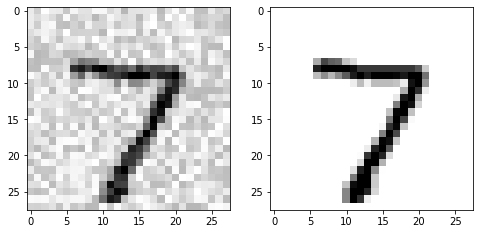

In [25]:
fig, ax = plt.subplots(1,2, figsize = (8,4))

ax[0].imshow(X_test_mod[0].reshape(28,28), cmap = 'binary')
ax[1].imshow(X_test[0].reshape(28,28), cmap = 'binary')



A la izquierda está la imagen de entrada ruidosa y a la derecha está la imagen de destino limpia.

Ahora entrenemos el clasificador y hagamos que limpie esta imagen:

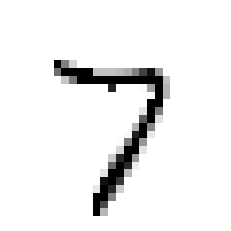

In [26]:
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)

¡Parece lo suficientemente cerca del objetivo! 

Con esto concluye nuestro recorrido de clasificación.

Ahora debe saber:  

* cómo seleccionar buenas métricas para las tareas de clasificación, 
* elegir la compensación adecuada de precisión/recuperación, 
* comparar clasificadores y, en general, crear buenos sistemas de clasificación para una variedad de tareas.

## Referencias  

* Cuaderno sobre Clasificación de Geron: https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb

In [56]:
np.random.randint(1,7) 



2

* Primer grupo: 4
* Segundo grupo: 1
* Tercer grupo: 5
* cuarto grupo: 3
* quinto grupo: 2
* sexto grupo: 6